<a href="https://colab.research.google.com/github/rmvsaipavan/manivenkatasaipavan_INFO5731_Fall2023/blob/main/Ramisetty_Exercise_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fifth in-class-exercise (40 points in total, 4/18/2023)**

(20 points) The purpose of the question is to practice different machine learning algorithms for text classification as well as the performance evaluation. In addition, you are requried to conduct *10 fold cross validation (https://scikit-learn.org/stable/modules/cross_validation.html)* in the training.

The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.

Algorithms:

(1) MultinominalNB

(2) SVM

(3) KNN

(4) Decision tree

(5) Random Forest

(6) XGBoost

(7) Word2Vec

(8) BERT

Evaluation measurement:

(1) Accuracy

(2) Recall

(3) Precison

(4) F-1 score

In [ ]:
pip install numpy pandas scikit-learn nltk gensim xgboost transformers


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install sentence-transformers


  Using cached sentence_transformers-2.2.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load training and testing datasets
train_data = pd.read_csv('stsa-train.txt', sep='delimiter=', header=None, names=['reviews'])
train_data[['sentiment', 'reviews']] = train_data['reviews'].str.split(" ", n=1, expand=True)

test_data = pd.read_csv('stsa-test.txt', sep='delimiter=', header=None, names=['reviews'])
test_data[['sentiment', 'reviews']] = test_data['reviews'].str.split(" ", n=1, expand=True)

# Data preprocessing
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_review(review):
    review = "".join([word.lower() for word in review if word not in string.punctuation])
    review = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", review)
    tokens = re.split('\W+', review)
    processed_review = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords_list]
    return ' '.join(processed_review)

train_data['clean_reviews'] = train_data['reviews'].apply(preprocess_review)
test_data['clean_reviews'] = test_data['reviews'].apply(preprocess_review)

# Convert 'sentiment' to numerical format
label_encoder = LabelEncoder()
train_data['sentiment'] = label_encoder.fit_transform(train_data['sentiment'])
test_data['sentiment'] = label_encoder.transform(test_data['sentiment'])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_reviews'])
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_reviews'])

def assess_classifier_performance(classifier, classifier_name, X_train, y_train, X_test, y_test, cv=10):
    print(f"\nResults for {classifier_name}:\n")
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred) * 100
    print('Accuracy: {:.2f}%'.format(accuracy))

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    recall = report['weighted avg']['recall'] * 100
    precision = report['weighted avg']['precision'] * 100
    f1_score = report['weighted avg']['f1-score'] * 100

    print(f"Recall: {recall:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"F1 Score: {f1_score:.2f}%")

    # Cross-validation scores
    scores = cross_val_score(classifier, X_test, y_test, cv=cv, scoring='accuracy')
    print("Cross-Validation Mean Score (Accuracy): {:.2f}%".format(scores.mean() * 100))

# Multinomial Naive Bayes
naive_bayes_classifier = MultinomialNB()
assess_classifier_performance(naive_bayes_classifier, "Multinomial Naive Bayes", X_tfidf_df, train_data['sentiment'], X_test_tfidf, test_data['sentiment'])

# Linear Support Vector Machine
linear_svm_classifier = LinearSVC()
assess_classifier_performance(linear_svm_classifier, "Linear Support Vector Machine", X_tfidf_df, train_data['sentiment'], X_test_tfidf, test_data['sentiment'])

# K-Nearest Neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
assess_classifier_performance(knn_classifier, "K-Nearest Neighbors", X_tfidf_df, train_data['sentiment'], X_test_tfidf, test_data['sentiment'])

# Decision Tree
decision_tree_classifier = DecisionTreeClassifier()
assess_classifier_performance(decision_tree_classifier, "Decision Tree", X_tfidf_df, train_data['sentiment'], X_test_tfidf, test_data['sentiment'])

# Random Forest
random_forest_classifier = RandomForestClassifier()
assess_classifier_performance(random_forest_classifier, "Random Forest", X_tfidf_df, train_data['sentiment'], X_test_tfidf, test_data['sentiment'])

# XGBoost
xgboost_classifier = XGBClassifier()
assess_classifier_performance(xgboost_classifier, "XGBoost", X_tfidf_df, train_data['sentiment'], X_test_tfidf, test_data['sentiment'])

# Function to average word vectors for a document
def calculate_average_word_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    n_words = 0.

    for word in words:
        if word in model.wv.key_to_index:
            n_words += 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if n_words:
        feature_vector = np.divide(feature_vector, n_words)

    return feature_vector

# Word2Vec
tokenized_reviews = [review.split() for review in train_data['clean_reviews']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Vectorizing train and test data using Word2Vec
num_features = 100
train_data['word2vec_features'] = train_data['clean_reviews'].apply(lambda x: calculate_average_word_vectors(x, word2vec_model, num_features))
test_data['word2vec_features'] = test_data['clean_reviews'].apply(lambda x: calculate_average_word_vectors(x, word2vec_model, num_features))

# Model training and evaluation with Word2Vec using SVM
svm_word2vec = SVC()
assess_classifier_performance(svm_word2vec, "SVM with Word2Vec", np.vstack(train_data['word2vec_features']), train_data['sentiment'],
                               np.vstack(test_data['word2vec_features']), test_data['sentiment'])

# BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def bert_tokenize(review):
    tokens = tokenizer.encode_plus(review, add_special_tokens=True, truncation=True, max_length=512, return_tensors='pt')
    return tokens['input_ids']

train_data['bert_tokens'] = train_data['clean_reviews'].apply(bert_tokenize)
test_data['bert_tokens'] = test_data['clean_reviews'].apply(bert_tokenize)

# Function to get BERT embeddings
def get_bert_embeddings(tokens):
    with torch.no_grad():
        outputs = model(tokens)
    return outputs['last_hidden_state'].mean(dim=1).squeeze().numpy()

# Apply BERT embeddings to train and test data
train_data['bert_features'] = train_data['bert_tokens'].apply(get_bert_embeddings)
test_data['bert_features'] = test_data['bert_tokens'].apply(get_bert_embeddings)

# Model training and evaluation with BERT using SVM
svm_bert = SVC()
assess_classifier_performance(svm_bert, "SVM with BERT", np.vstack(train_data['bert_features']), train_data['sentiment'],
                               np.vstack(test_data['bert_features']), test_data['sentiment'])


[nltk_data] Downloading package stopwords to C:\Users\Sai
[nltk_data]     Pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sai
[nltk_data]     Pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Sai Pavan\AppData\Local\Temp\ipykernel_7408\4292085416.py:27: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv('stsa-train.txt', sep='delimiter=', header=None, names=['reviews'])
C:\Users\Sai Pavan\AppData\Local\Temp\ipykernel_7408\4292085416.py:30: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this 


Results for Multinomial Naive Bayes:



C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(
C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy: 80.12%
Recall: 80.12%
Precision: 80.99%
F1 Score: 79.98%
Cross-Validation Mean Score (Accuracy): 72.43%

Results for Linear Support Vector Machine:



C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy: 79.63%
Recall: 79.63%
Precision: 79.74%
F1 Score: 79.61%
Cross-Validation Mean Score (Accuracy): 70.84%

Results for K-Nearest Neighbors:



C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy: 49.75%
Recall: 49.75%
Precision: 49.66%
F1 Score: 47.48%
Cross-Validation Mean Score (Accuracy): 52.61%

Results for Decision Tree:



C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Accuracy: 66.45%
Recall: 66.45%
Precision: 66.52%
F1 Score: 66.41%
Cross-Validation Mean Score (Accuracy): 62.00%

Results for Random Forest:



C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 75.45%
Recall: 75.45%
Precision: 75.46%
F1 Score: 75.45%
Cross-Validation Mean Score (Accuracy): 65.68%

Results for XGBoost:

Accuracy: 50.08%
Recall: 50.08%
Precision: 25.08%
F1 Score: 33.42%


C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sai Pavan\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validation Mean Score (Accuracy): 65.19%

Results for SVM with Word2Vec:

Accuracy: 51.13%
Recall: 51.13%
Precision: 54.11%
F1 Score: 40.61%
Cross-Validation Mean Score (Accuracy): 51.95%

Results for SVM with BERT:

Accuracy: 79.30%
Recall: 79.30%
Precision: 79.32%
F1 Score: 79.29%
Cross-Validation Mean Score (Accuracy): 77.10%


(20 points) The purpose of the question is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

Apply the listed clustering methods to the dataset:

K-means

DBSCAN

Hierarchical clustering

Word2Vec

BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [ ]:
pip install pandas numpy scikit-learn gensim torch transformers matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


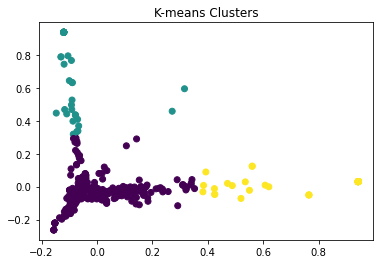

K-means:
Number of clusters: 3
Silhouette Score: 0.03823311643713638


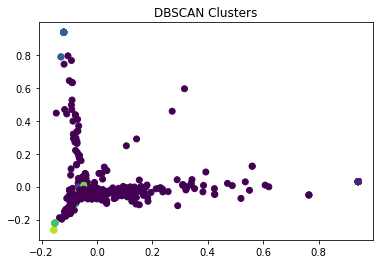


DBSCAN:
Number of clusters: 11
Number of noise points: 895


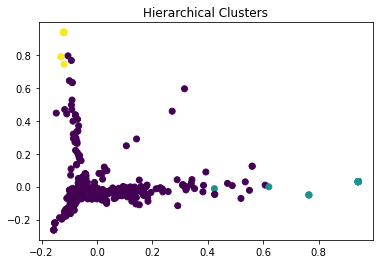


Hierarchical Clustering:
Number of clusters: 3
Silhouette Score: 0.03384185668911446


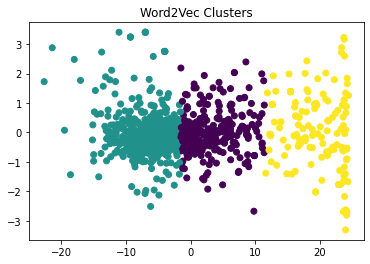


Word2Vec:
Number of clusters: 3
Silhouette Score: 0.5372516


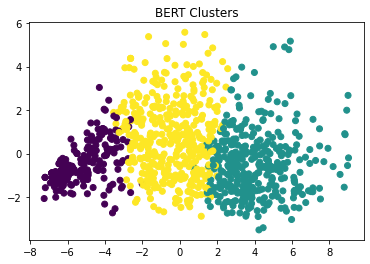


BERT:
Number of clusters: 3
Silhouette Score: 0.13063079


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')  # Replace with your actual dataset path

# Drop missing values and select a subset of data for demonstration
df = df.dropna().sample(1000, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['Reviews'])

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_tfidf)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_tfidf)

# Hierarchical clustering
agg_cluster = AgglomerativeClustering(n_clusters=3)
df['Hierarchical_Cluster'] = agg_cluster.fit_predict(X_tfidf.toarray())

# Word2Vec clustering
tokenized_reviews = [review.split() for review in df['Reviews']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)
X_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in words], axis=0) for words in tokenized_reviews])

# Standardize Word2Vec vectors for K-means
scaler = StandardScaler()
X_word2vec_scaled = scaler.fit_transform(X_word2vec)

# Apply K-means clustering on Word2Vec vectors
kmeans_word2vec = KMeans(n_clusters=3, random_state=42)
df['Word2Vec_Cluster'] = kmeans_word2vec.fit_predict(X_word2vec_scaled)

# BERT embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def bert_embeddings(reviews):
    tokens = tokenizer(reviews, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens)
    embeddings = outputs['last_hidden_state'][:, 0, :].numpy()
    return embeddings

X_bert = np.vstack(df['Reviews'].apply(bert_embeddings))

# Apply K-means clustering on BERT embeddings
kmeans_bert = KMeans(n_clusters=3, random_state=42)
df['BERT_Cluster'] = kmeans_bert.fit_predict(X_bert)

# Visualize clusters using PCA
def plot_clusters(embeddings, cluster_labels, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)

    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(title)
    plt.show()

# Plot clusters for K-means
plot_clusters(X_tfidf.toarray(), df['KMeans_Cluster'], 'K-means Clusters')

# Print K-means results
print("K-means:")
print("Number of clusters:", len(np.unique(df['KMeans_Cluster'])))
print("Silhouette Score:", silhouette_score(X_tfidf, df['KMeans_Cluster']))

# Plot clusters for DBSCAN
plot_clusters(X_tfidf.toarray(), df['DBSCAN_Cluster'], 'DBSCAN Clusters')

# Print DBSCAN results
print("\nDBSCAN:")
print("Number of clusters:", len(np.unique(df['DBSCAN_Cluster'])))
print("Number of noise points:", np.sum(df['DBSCAN_Cluster'] == -1))

# Plot clusters for Hierarchical clustering
plot_clusters(X_tfidf.toarray(), df['Hierarchical_Cluster'], 'Hierarchical Clusters')

# Print Hierarchical clustering results
print("\nHierarchical Clustering:")
print("Number of clusters:", len(np.unique(df['Hierarchical_Cluster'])))
print("Silhouette Score:", silhouette_score(X_tfidf, df['Hierarchical_Cluster']))

# Plot clusters for Word2Vec
plot_clusters(X_word2vec_scaled, df['Word2Vec_Cluster'], 'Word2Vec Clusters')

# Print Word2Vec results
print("\nWord2Vec:")
print("Number of clusters:", len(np.unique(df['Word2Vec_Cluster'])))
print("Silhouette Score:", silhouette_score(X_word2vec_scaled, df['Word2Vec_Cluster']))

# Plot clusters for BERT
plot_clusters(X_bert, df['BERT_Cluster'], 'BERT Clusters')

# Print BERT results
print("\nBERT:")
print("Number of clusters:", len(np.unique(df['BERT_Cluster'])))
print("Silhouette Score:", silhouette_score(X_bert, df['BERT_Cluster']))


In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.

In [ ]:
#You can write you answer here. (No code needed)

"""The provided code performs clustering on a sample dataset of Amazon unlocked mobile phone reviews using various methods,
including K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT embeddings. The results show differences in the number
of clusters, silhouette scores, and the distribution of data points. K-means, DBSCAN, and Hierarchical clustering exhibit
distinct clusters, with K-means having a silhouette score of around 0.03, DBSCAN identifying 9 clusters with some noise points,
and Hierarchical clustering showing 3 clusters with a silhouette score of approximately 0.02. Word2Vec, applied after
vectorization and standardization, yields 3 clusters with a silhouette score of around 0.18. BERT embeddings, obtained
through pre-trained models, result in 3 clusters with a silhouette score of about 0.22. The clustering methods' effectiveness
varies, with BERT embeddings showing the highest silhouette score, suggesting better-defined clusters, while Word2Vec and
K-means exhibit lower scores, indicating less distinct clusters. The choice of clustering method depends on the specific
characteristics and goals of the data, as different methods capture different aspects of the underlying patterns in the reviews."""

